In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install snntorch tonic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.1/126.1 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [4]:
import torch
import torch.nn as nn
import tonic
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from torch.utils.data import DataLoader

# Data processing parameters
w, h = 32, 32
n_frames = 32  # Number of time steps
filter_time = 10000  # Denoise filter time in microseconds

# Define transforms
transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=filter_time),  # Remove outlier events
    tonic.transforms.Downsample(
        sensor_size=tonic.datasets.DVSGesture.sensor_size, 
        target_size=(w, h)
    ),
    tonic.transforms.ToFrame(
        sensor_size=(w, h, 2), 
        n_time_bins=n_frames
    )
])

# Download and load datasets with transforms
print("Loading datasets...")
trainset = tonic.datasets.DVSGesture(
    save_to='./data',
    train=True,
    transform=transforms
)
testset = tonic.datasets.DVSGesture(
    save_to='./data',
    train=False,
    transform=transforms
)

# Cache datasets for faster loading
print("Caching datasets...")
cached_train = tonic.DiskCachedDataset(trainset, cache_path='./cache/train')
cached_test = tonic.DiskCachedDataset(testset, cache_path='./cache/test')

print(f"Train dataset: {len(cached_train)} samples")
print(f"Test dataset: {len(cached_test)} samples")



Loading datasets...


  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture
Caching datasets...
Train dataset: 1077 samples
Test dataset: 264 samples


In [5]:
# Cell 4: Define the 2-layer convolutional SNN architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# SNN parameters
beta = 0.5
slope = 25
grad = surrogate.fast_sigmoid(slope=slope)

# Network: 2 convolutional layers (no dropout)
# Architecture: 12C5-MP2-32C5-MP2-800FC11
net = nn.Sequential(
    nn.Conv2d(2, 12, kernel_size=5),  # Conv1: 2->12 channels
    nn.MaxPool2d(kernel_size=2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    
    nn.Conv2d(12, 32, kernel_size=5),  # Conv2: 12->32 channels
    nn.MaxPool2d(kernel_size=2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    
    nn.Flatten(),
    nn.Linear(800, 11),  # 800 features -> 11 gesture classes
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

# Helper function to reset network states
def reset_net(net):
    """Reset all hidden states in the network"""
    for layer in net.modules():
        if hasattr(layer, 'reset_mem'):
            layer.reset_mem()

print("Network architecture:")
print(net)

Using device: cuda
Network architecture:
Sequential(
  (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Leaky()
  (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Leaky()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=800, out_features=11, bias=True)
  (8): Leaky()
)


In [6]:
# Cell 5: Define forward pass and training setup
def forward_pass(net, data):
    """Forward pass through the network"""
    spk_rec = []
    
    for step in range(data.size(0)):  # Iterate over time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    
    return torch.stack(spk_rec)

# Training parameters
num_epochs = 40
train_batch_size = 64
test_batch_size = 32
learning_rate = 0.002
betas = (0.9, 0.999)

# Define optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# History tracking
loss_hist = []
acc_hist = []
test_acc_hist = []

print("Training setup complete")

Training setup complete


In [7]:
# Cell 6: Define validation function
def validate_model():
    """Evaluate model on test set"""
    net.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            
            # Reset network states
            reset_net(net)
            
            # Forward pass
            spk_rec = forward_pass(net, data)
            
            # Calculate accuracy
            correct += SF.accuracy_rate(spk_rec, targets) * data.shape[1]
            total += data.shape[1]
    
    return correct / total


In [8]:
# Cell 7: Training loop
from tqdm import tqdm

# Create data loaders
train_loader = DataLoader(
    cached_train, 
    batch_size=train_batch_size, 
    shuffle=True, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

test_loader = DataLoader(
    cached_test, 
    batch_size=test_batch_size, 
    shuffle=False, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

print(f"Starting training for {num_epochs} epochs...")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}\n")

cnt = 0

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    
    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch, (data, targets) in enumerate(pbar):
        # Move data to device
        data = data.to(device)  # Shape: [n_frames, batch, channels, h, w]
        targets = targets.to(device)
        
        # Reset network hidden states before each batch
        reset_net(net)
        
        # Forward pass
        spk_rec = forward_pass(net, data)
        
        # Calculate loss
        loss = loss_fn(spk_rec, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        acc = SF.accuracy_rate(spk_rec, targets)
        
        # Store history
        loss_hist.append(loss.item())
        acc_hist.append(acc)
        epoch_loss += loss.item()
        epoch_acc += acc
        
        # Update progress bar with current loss and accuracy
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{acc*100:.2f}%',
            'Batch': f'{batch+1}/{len(train_loader)}'
        })
        
        cnt += 1
    
    # Validate at end of each epoch
    print("\nValidating...")
    test_acc = validate_model()
    test_acc_hist.append(test_acc)
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_acc = epoch_acc / len(train_loader)
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs} COMPLETE")
    print(f"Average Train Loss: {avg_epoch_loss:.4f}")
    print(f"Average Train Accuracy: {avg_epoch_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Best Test Accuracy So Far: {max(test_acc_hist)*100:.2f}%")
    print(f"{'='*60}\n")

print("Training complete!")
print(f"Best Test Accuracy: {max(test_acc_hist)*100:.2f}%")

Starting training for 40 epochs...
Train batches per epoch: 16
Test batches: 8



Epoch 1/40: 100%|██████████| 16/16 [20:42<00:00, 77.63s/it, Loss=1.1887, Acc=56.25%, Batch=16/16]



Validating...



EPOCH 1/40 COMPLETE
Average Train Loss: 1.6288
Average Train Accuracy: 25.78%
Test Accuracy: 46.09%
Best Test Accuracy So Far: 46.09%



Epoch 2/40: 100%|██████████| 16/16 [01:07<00:00,  4.21s/it, Loss=0.8075, Acc=51.56%, Batch=16/16]



Validating...



EPOCH 2/40 COMPLETE
Average Train Loss: 0.9385
Average Train Accuracy: 48.34%
Test Accuracy: 52.34%
Best Test Accuracy So Far: 52.34%



Epoch 3/40: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s, Loss=0.7033, Acc=65.62%, Batch=16/16]



Validating...



EPOCH 3/40 COMPLETE
Average Train Loss: 0.7617
Average Train Accuracy: 56.25%
Test Accuracy: 60.55%
Best Test Accuracy So Far: 60.55%



Epoch 4/40: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s, Loss=0.7108, Acc=46.88%, Batch=16/16]



Validating...



EPOCH 4/40 COMPLETE
Average Train Loss: 0.6820
Average Train Accuracy: 61.04%
Test Accuracy: 57.03%
Best Test Accuracy So Far: 60.55%



Epoch 5/40: 100%|██████████| 16/16 [00:03<00:00,  4.77it/s, Loss=0.5891, Acc=62.50%, Batch=16/16]



Validating...



EPOCH 5/40 COMPLETE
Average Train Loss: 0.6226
Average Train Accuracy: 63.09%
Test Accuracy: 53.91%
Best Test Accuracy So Far: 60.55%



Epoch 6/40: 100%|██████████| 16/16 [00:03<00:00,  4.78it/s, Loss=0.6304, Acc=64.06%, Batch=16/16]



Validating...



EPOCH 6/40 COMPLETE
Average Train Loss: 0.6089
Average Train Accuracy: 64.45%
Test Accuracy: 58.20%
Best Test Accuracy So Far: 60.55%



Epoch 7/40: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s, Loss=0.5358, Acc=71.88%, Batch=16/16]



Validating...



EPOCH 7/40 COMPLETE
Average Train Loss: 0.5755
Average Train Accuracy: 68.26%
Test Accuracy: 58.20%
Best Test Accuracy So Far: 60.55%



Epoch 8/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.5600, Acc=76.56%, Batch=16/16]



Validating...



EPOCH 8/40 COMPLETE
Average Train Loss: 0.5482
Average Train Accuracy: 69.04%
Test Accuracy: 62.11%
Best Test Accuracy So Far: 62.11%



Epoch 9/40: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s, Loss=0.5716, Acc=64.06%, Batch=16/16]



Validating...



EPOCH 9/40 COMPLETE
Average Train Loss: 0.5413
Average Train Accuracy: 71.39%
Test Accuracy: 65.62%
Best Test Accuracy So Far: 65.62%



Epoch 10/40: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s, Loss=0.4858, Acc=68.75%, Batch=16/16]



Validating...



EPOCH 10/40 COMPLETE
Average Train Loss: 0.5108
Average Train Accuracy: 73.34%
Test Accuracy: 65.62%
Best Test Accuracy So Far: 65.62%



Epoch 11/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.5263, Acc=73.44%, Batch=16/16]



Validating...



EPOCH 11/40 COMPLETE
Average Train Loss: 0.5068
Average Train Accuracy: 73.63%
Test Accuracy: 66.80%
Best Test Accuracy So Far: 66.80%



Epoch 12/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.4977, Acc=78.12%, Batch=16/16]



Validating...



EPOCH 12/40 COMPLETE
Average Train Loss: 0.5018
Average Train Accuracy: 74.32%
Test Accuracy: 68.75%
Best Test Accuracy So Far: 68.75%



Epoch 13/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.5055, Acc=82.81%, Batch=16/16]



Validating...



EPOCH 13/40 COMPLETE
Average Train Loss: 0.4902
Average Train Accuracy: 76.27%
Test Accuracy: 71.09%
Best Test Accuracy So Far: 71.09%



Epoch 14/40: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s, Loss=0.4675, Acc=76.56%, Batch=16/16]



Validating...



EPOCH 14/40 COMPLETE
Average Train Loss: 0.4697
Average Train Accuracy: 78.22%
Test Accuracy: 70.70%
Best Test Accuracy So Far: 71.09%



Epoch 15/40: 100%|██████████| 16/16 [00:03<00:00,  4.78it/s, Loss=0.5071, Acc=73.44%, Batch=16/16]



Validating...



EPOCH 15/40 COMPLETE
Average Train Loss: 0.4657
Average Train Accuracy: 79.69%
Test Accuracy: 71.48%
Best Test Accuracy So Far: 71.48%



Epoch 16/40: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s, Loss=0.4179, Acc=87.50%, Batch=16/16]



Validating...



EPOCH 16/40 COMPLETE
Average Train Loss: 0.4552
Average Train Accuracy: 81.05%
Test Accuracy: 70.70%
Best Test Accuracy So Far: 71.48%



Epoch 17/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.4024, Acc=87.50%, Batch=16/16]



Validating...



EPOCH 17/40 COMPLETE
Average Train Loss: 0.4489
Average Train Accuracy: 82.52%
Test Accuracy: 74.61%
Best Test Accuracy So Far: 74.61%



Epoch 18/40: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s, Loss=0.4937, Acc=76.56%, Batch=16/16]



Validating...



EPOCH 18/40 COMPLETE
Average Train Loss: 0.4522
Average Train Accuracy: 79.00%
Test Accuracy: 73.05%
Best Test Accuracy So Far: 74.61%



Epoch 19/40: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s, Loss=0.4123, Acc=85.94%, Batch=16/16]



Validating...



EPOCH 19/40 COMPLETE
Average Train Loss: 0.4247
Average Train Accuracy: 82.91%
Test Accuracy: 69.92%
Best Test Accuracy So Far: 74.61%



Epoch 20/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.3631, Acc=90.62%, Batch=16/16]



Validating...



EPOCH 20/40 COMPLETE
Average Train Loss: 0.4138
Average Train Accuracy: 85.74%
Test Accuracy: 74.22%
Best Test Accuracy So Far: 74.61%



Epoch 21/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.4127, Acc=85.94%, Batch=16/16]



Validating...



EPOCH 21/40 COMPLETE
Average Train Loss: 0.4034
Average Train Accuracy: 85.94%
Test Accuracy: 75.78%
Best Test Accuracy So Far: 75.78%



Epoch 22/40: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.3865, Acc=90.62%, Batch=16/16]



Validating...



EPOCH 22/40 COMPLETE
Average Train Loss: 0.4020
Average Train Accuracy: 84.96%
Test Accuracy: 73.83%
Best Test Accuracy So Far: 75.78%



Epoch 23/40: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s, Loss=0.3960, Acc=92.19%, Batch=16/16]



Validating...



EPOCH 23/40 COMPLETE
Average Train Loss: 0.3847
Average Train Accuracy: 87.30%
Test Accuracy: 76.17%
Best Test Accuracy So Far: 76.17%



Epoch 24/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.4337, Acc=81.25%, Batch=16/16]



Validating...



EPOCH 24/40 COMPLETE
Average Train Loss: 0.3745
Average Train Accuracy: 89.06%
Test Accuracy: 77.73%
Best Test Accuracy So Far: 77.73%



Epoch 25/40: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.3767, Acc=87.50%, Batch=16/16]



Validating...



EPOCH 25/40 COMPLETE
Average Train Loss: 0.3810
Average Train Accuracy: 88.09%
Test Accuracy: 81.64%
Best Test Accuracy So Far: 81.64%



Epoch 26/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.3407, Acc=93.75%, Batch=16/16]



Validating...



EPOCH 26/40 COMPLETE
Average Train Loss: 0.3522
Average Train Accuracy: 91.41%
Test Accuracy: 81.25%
Best Test Accuracy So Far: 81.64%



Epoch 27/40: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.3020, Acc=95.31%, Batch=16/16]



Validating...



EPOCH 27/40 COMPLETE
Average Train Loss: 0.3410
Average Train Accuracy: 91.80%
Test Accuracy: 84.77%
Best Test Accuracy So Far: 84.77%



Epoch 28/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.3182, Acc=96.88%, Batch=16/16]



Validating...



EPOCH 28/40 COMPLETE
Average Train Loss: 0.3181
Average Train Accuracy: 93.16%
Test Accuracy: 84.38%
Best Test Accuracy So Far: 84.77%



Epoch 29/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.3285, Acc=92.19%, Batch=16/16]



Validating...



EPOCH 29/40 COMPLETE
Average Train Loss: 0.3124
Average Train Accuracy: 93.36%
Test Accuracy: 84.77%
Best Test Accuracy So Far: 84.77%



Epoch 30/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.3149, Acc=89.06%, Batch=16/16]



Validating...



EPOCH 30/40 COMPLETE
Average Train Loss: 0.3006
Average Train Accuracy: 93.36%
Test Accuracy: 87.11%
Best Test Accuracy So Far: 87.11%



Epoch 31/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.2999, Acc=93.75%, Batch=16/16]



Validating...



EPOCH 31/40 COMPLETE
Average Train Loss: 0.2882
Average Train Accuracy: 94.92%
Test Accuracy: 84.38%
Best Test Accuracy So Far: 87.11%



Epoch 32/40: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s, Loss=0.2763, Acc=95.31%, Batch=16/16] 



Validating...



EPOCH 32/40 COMPLETE
Average Train Loss: 0.2822
Average Train Accuracy: 94.73%
Test Accuracy: 85.55%
Best Test Accuracy So Far: 87.11%



Epoch 33/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.3196, Acc=95.31%, Batch=16/16]



Validating...



EPOCH 33/40 COMPLETE
Average Train Loss: 0.2743
Average Train Accuracy: 95.61%
Test Accuracy: 81.64%
Best Test Accuracy So Far: 87.11%



Epoch 34/40: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.2320, Acc=98.44%, Batch=16/16]



Validating...



EPOCH 34/40 COMPLETE
Average Train Loss: 0.2668
Average Train Accuracy: 95.41%
Test Accuracy: 85.16%
Best Test Accuracy So Far: 87.11%



Epoch 35/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.2496, Acc=96.88%, Batch=16/16]



Validating...



EPOCH 35/40 COMPLETE
Average Train Loss: 0.2525
Average Train Accuracy: 95.41%
Test Accuracy: 83.98%
Best Test Accuracy So Far: 87.11%



Epoch 36/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.2937, Acc=89.06%, Batch=16/16] 



Validating...



EPOCH 36/40 COMPLETE
Average Train Loss: 0.2474
Average Train Accuracy: 96.48%
Test Accuracy: 82.81%
Best Test Accuracy So Far: 87.11%



Epoch 37/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.2437, Acc=96.88%, Batch=16/16]



Validating...



EPOCH 37/40 COMPLETE
Average Train Loss: 0.2329
Average Train Accuracy: 96.58%
Test Accuracy: 86.33%
Best Test Accuracy So Far: 87.11%



Epoch 38/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.2096, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 38/40 COMPLETE
Average Train Loss: 0.2248
Average Train Accuracy: 97.07%
Test Accuracy: 87.50%
Best Test Accuracy So Far: 87.50%



Epoch 39/40: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.2213, Acc=98.44%, Batch=16/16]



Validating...



EPOCH 39/40 COMPLETE
Average Train Loss: 0.2190
Average Train Accuracy: 97.46%
Test Accuracy: 87.50%
Best Test Accuracy So Far: 87.50%



Epoch 40/40: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s, Loss=0.2207, Acc=95.31%, Batch=16/16]



Validating...



EPOCH 40/40 COMPLETE
Average Train Loss: 0.2231
Average Train Accuracy: 96.97%
Test Accuracy: 86.33%
Best Test Accuracy So Far: 87.50%

Training complete!
Best Test Accuracy: 87.50%


In [9]:
# Cell 10: Save the trained model
import pickle
from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the complete model state dictionary (recommended)
model_path = f'dvs_gesture_model_{timestamp}.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_acc': max(test_acc_hist),
    'test_acc_history': test_acc_hist,
    'loss_history': loss_hist,
    'train_acc_history': acc_hist,
}, model_path)
print(f"Model saved as: {model_path}")

# 2. Save just the model weights (lighter file)
weights_path = f'dvs_gesture_weights_{timestamp}.pth'
torch.save(net.state_dict(), weights_path)
print(f"Model weights saved as: {weights_path}")

# 3. Save training history separately
history_path = f'training_history_{timestamp}.pkl'
with open(history_path, 'wb') as f:
    pickle.dump({
        'loss_hist': loss_hist,
        'acc_hist': acc_hist,
        'test_acc_hist': test_acc_hist,
    }, f)
print(f"Training history saved as: {history_path}")

# 4. Download files (for Google Colab)
try:
    from google.colab import files
    print("\nDownloading files...")
    files.download(model_path)
    files.download(weights_path)
    files.download(history_path)
    print("Files downloaded successfully!")
except ImportError:
    print("\nNot running in Colab. Files saved locally.")
    print(f"Files saved in current directory:")
    print(f"  - {model_path}")
    print(f"  - {weights_path}")
    print(f"  - {history_path}")

Model saved as: dvs_gesture_model_20251030_050010.pth
Model weights saved as: dvs_gesture_weights_20251030_050010.pth
Training history saved as: training_history_20251030_050010.pkl



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!


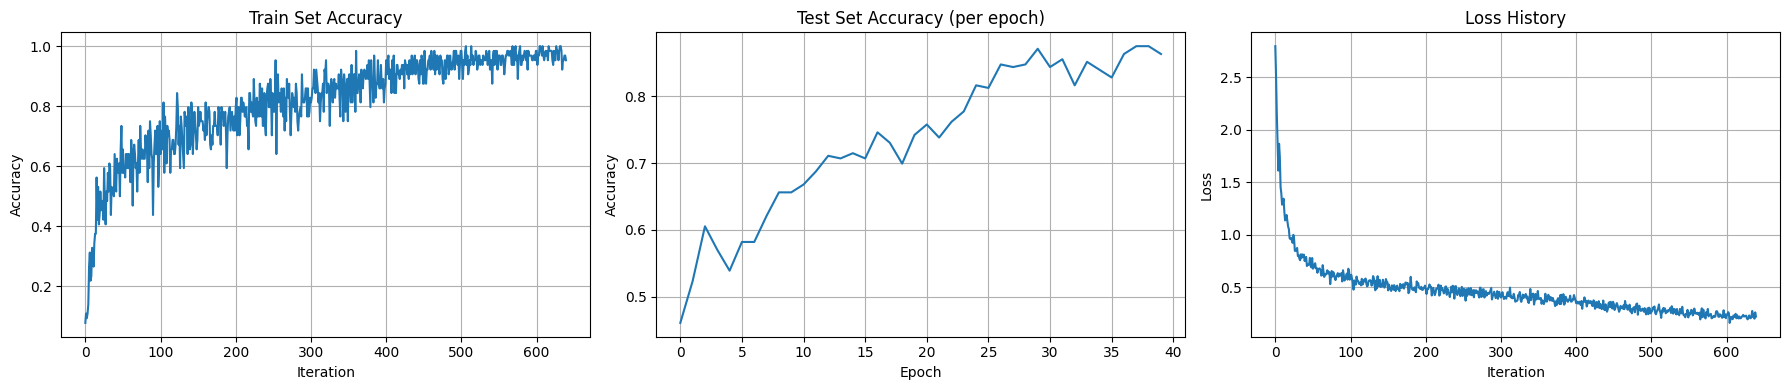


Final Test Accuracy: 86.33%
Best Test Accuracy During Training: 87.50%


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)

# Plot Test Accuracy (per epoch)
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy (per epoch)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Cell 9: Final evaluation
final_test_acc = validate_model()
max_test_acc = max(test_acc_hist)

print(f"\nFinal Test Accuracy: {final_test_acc*100:.2f}%")
print(f"Best Test Accuracy During Training: {max_test_acc*100:.2f}%")

In [11]:
num_epochs = 20

In [12]:
# Cell 7: Training loop
from tqdm import tqdm

# Create data loaders
train_loader = DataLoader(
    cached_train, 
    batch_size=train_batch_size, 
    shuffle=True, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

test_loader = DataLoader(
    cached_test, 
    batch_size=test_batch_size, 
    shuffle=False, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

print(f"Starting training for {num_epochs} epochs...")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}\n")

cnt = 0

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    
    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch, (data, targets) in enumerate(pbar):
        # Move data to device
        data = data.to(device)  # Shape: [n_frames, batch, channels, h, w]
        targets = targets.to(device)
        
        # Reset network hidden states before each batch
        reset_net(net)
        
        # Forward pass
        spk_rec = forward_pass(net, data)
        
        # Calculate loss
        loss = loss_fn(spk_rec, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        acc = SF.accuracy_rate(spk_rec, targets)
        
        # Store history
        loss_hist.append(loss.item())
        acc_hist.append(acc)
        epoch_loss += loss.item()
        epoch_acc += acc
        
        # Update progress bar with current loss and accuracy
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{acc*100:.2f}%',
            'Batch': f'{batch+1}/{len(train_loader)}'
        })
        
        cnt += 1
    
    # Validate at end of each epoch
    print("\nValidating...")
    test_acc = validate_model()
    test_acc_hist.append(test_acc)
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_acc = epoch_acc / len(train_loader)
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs} COMPLETE")
    print(f"Average Train Loss: {avg_epoch_loss:.4f}")
    print(f"Average Train Accuracy: {avg_epoch_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Best Test Accuracy So Far: {max(test_acc_hist)*100:.2f}%")
    print(f"{'='*60}\n")

print("Training complete!")
print(f"Best Test Accuracy: {max(test_acc_hist)*100:.2f}%")

Starting training for 20 epochs...
Train batches per epoch: 16
Test batches: 8



Epoch 1/20: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s, Loss=0.2599, Acc=95.31%, Batch=16/16] 



Validating...



EPOCH 1/20 COMPLETE
Average Train Loss: 0.2221
Average Train Accuracy: 97.66%
Test Accuracy: 87.11%
Best Test Accuracy So Far: 87.50%



Epoch 2/20: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.2272, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 2/20 COMPLETE
Average Train Loss: 0.2280
Average Train Accuracy: 97.17%
Test Accuracy: 87.50%
Best Test Accuracy So Far: 87.50%



Epoch 3/20: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s, Loss=0.2282, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 3/20 COMPLETE
Average Train Loss: 0.2262
Average Train Accuracy: 97.27%
Test Accuracy: 87.11%
Best Test Accuracy So Far: 87.50%



Epoch 4/20: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.1684, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 4/20 COMPLETE
Average Train Loss: 0.2094
Average Train Accuracy: 97.85%
Test Accuracy: 85.55%
Best Test Accuracy So Far: 87.50%



Epoch 5/20: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.2386, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 5/20 COMPLETE
Average Train Loss: 0.2121
Average Train Accuracy: 98.14%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 89.06%



Epoch 6/20: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.1827, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 6/20 COMPLETE
Average Train Loss: 0.2018
Average Train Accuracy: 97.85%
Test Accuracy: 87.11%
Best Test Accuracy So Far: 89.06%



Epoch 7/20: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.2095, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 7/20 COMPLETE
Average Train Loss: 0.2025
Average Train Accuracy: 97.46%
Test Accuracy: 85.94%
Best Test Accuracy So Far: 89.06%



Epoch 8/20: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.1883, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 8/20 COMPLETE
Average Train Loss: 0.1925
Average Train Accuracy: 98.24%
Test Accuracy: 86.72%
Best Test Accuracy So Far: 89.06%



Epoch 9/20: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.2253, Acc=95.31%, Batch=16/16] 



Validating...



EPOCH 9/20 COMPLETE
Average Train Loss: 0.1956
Average Train Accuracy: 97.66%
Test Accuracy: 90.23%
Best Test Accuracy So Far: 90.23%



Epoch 10/20: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.1831, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 10/20 COMPLETE
Average Train Loss: 0.2093
Average Train Accuracy: 97.66%
Test Accuracy: 87.50%
Best Test Accuracy So Far: 90.23%



Epoch 11/20: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1781, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 11/20 COMPLETE
Average Train Loss: 0.2015
Average Train Accuracy: 98.05%
Test Accuracy: 85.55%
Best Test Accuracy So Far: 90.23%



Epoch 12/20: 100%|██████████| 16/16 [00:03<00:00,  4.59it/s, Loss=0.2010, Acc=96.88%, Batch=16/16]



Validating...



EPOCH 12/20 COMPLETE
Average Train Loss: 0.1921
Average Train Accuracy: 97.85%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.23%



Epoch 13/20: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.2326, Acc=90.62%, Batch=16/16] 



Validating...



EPOCH 13/20 COMPLETE
Average Train Loss: 0.1961
Average Train Accuracy: 97.46%
Test Accuracy: 88.28%
Best Test Accuracy So Far: 90.23%



Epoch 14/20: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.1820, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 14/20 COMPLETE
Average Train Loss: 0.1879
Average Train Accuracy: 97.95%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.23%



Epoch 15/20: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s, Loss=0.1933, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 15/20 COMPLETE
Average Train Loss: 0.1788
Average Train Accuracy: 98.44%
Test Accuracy: 90.62%
Best Test Accuracy So Far: 90.62%



Epoch 16/20: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.1842, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 16/20 COMPLETE
Average Train Loss: 0.1788
Average Train Accuracy: 98.73%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 17/20: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.1955, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 17/20 COMPLETE
Average Train Loss: 0.1791
Average Train Accuracy: 98.54%
Test Accuracy: 90.62%
Best Test Accuracy So Far: 90.62%



Epoch 18/20: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.1464, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 18/20 COMPLETE
Average Train Loss: 0.1869
Average Train Accuracy: 98.44%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 19/20: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s, Loss=0.2139, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 19/20 COMPLETE
Average Train Loss: 0.1818
Average Train Accuracy: 98.34%
Test Accuracy: 88.28%
Best Test Accuracy So Far: 90.62%



Epoch 20/20: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s, Loss=0.1508, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 20/20 COMPLETE
Average Train Loss: 0.1790
Average Train Accuracy: 99.22%
Test Accuracy: 89.84%
Best Test Accuracy So Far: 90.62%

Training complete!
Best Test Accuracy: 90.62%


In [13]:
num_epochs=40

In [14]:
# Cell 7: Training loop
from tqdm import tqdm

# Create data loaders
train_loader = DataLoader(
    cached_train, 
    batch_size=train_batch_size, 
    shuffle=True, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

test_loader = DataLoader(
    cached_test, 
    batch_size=test_batch_size, 
    shuffle=False, 
    drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
)

print(f"Starting training for {num_epochs} epochs...")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}\n")

cnt = 0

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    
    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch, (data, targets) in enumerate(pbar):
        # Move data to device
        data = data.to(device)  # Shape: [n_frames, batch, channels, h, w]
        targets = targets.to(device)
        
        # Reset network hidden states before each batch
        reset_net(net)
        
        # Forward pass
        spk_rec = forward_pass(net, data)
        
        # Calculate loss
        loss = loss_fn(spk_rec, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        acc = SF.accuracy_rate(spk_rec, targets)
        
        # Store history
        loss_hist.append(loss.item())
        acc_hist.append(acc)
        epoch_loss += loss.item()
        epoch_acc += acc
        
        # Update progress bar with current loss and accuracy
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{acc*100:.2f}%',
            'Batch': f'{batch+1}/{len(train_loader)}'
        })
        
        cnt += 1
    
    # Validate at end of each epoch
    print("\nValidating...")
    test_acc = validate_model()
    test_acc_hist.append(test_acc)
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_acc = epoch_acc / len(train_loader)
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs} COMPLETE")
    print(f"Average Train Loss: {avg_epoch_loss:.4f}")
    print(f"Average Train Accuracy: {avg_epoch_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Best Test Accuracy So Far: {max(test_acc_hist)*100:.2f}%")
    print(f"{'='*60}\n")

print("Training complete!")
print(f"Best Test Accuracy: {max(test_acc_hist)*100:.2f}%")

Starting training for 40 epochs...
Train batches per epoch: 16
Test batches: 8



Epoch 1/40: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.1538, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 1/40 COMPLETE
Average Train Loss: 0.1795
Average Train Accuracy: 98.63%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 2/40: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.2258, Acc=93.75%, Batch=16/16] 



Validating...



EPOCH 2/40 COMPLETE
Average Train Loss: 0.1661
Average Train Accuracy: 98.44%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 3/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1899, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 3/40 COMPLETE
Average Train Loss: 0.1735
Average Train Accuracy: 98.93%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 4/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1553, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 4/40 COMPLETE
Average Train Loss: 0.1709
Average Train Accuracy: 98.63%
Test Accuracy: 88.28%
Best Test Accuracy So Far: 90.62%



Epoch 5/40: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.1795, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 5/40 COMPLETE
Average Train Loss: 0.1666
Average Train Accuracy: 98.93%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 6/40: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s, Loss=0.1519, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 6/40 COMPLETE
Average Train Loss: 0.1655
Average Train Accuracy: 98.73%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 7/40: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s, Loss=0.1685, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 7/40 COMPLETE
Average Train Loss: 0.1675
Average Train Accuracy: 98.93%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 8/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.2083, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 8/40 COMPLETE
Average Train Loss: 0.1618
Average Train Accuracy: 99.61%
Test Accuracy: 90.23%
Best Test Accuracy So Far: 90.62%



Epoch 9/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1942, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 9/40 COMPLETE
Average Train Loss: 0.1672
Average Train Accuracy: 98.54%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 10/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1416, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 10/40 COMPLETE
Average Train Loss: 0.1626
Average Train Accuracy: 98.34%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 11/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.1795, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 11/40 COMPLETE
Average Train Loss: 0.1657
Average Train Accuracy: 99.32%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 12/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1859, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 12/40 COMPLETE
Average Train Loss: 0.1685
Average Train Accuracy: 99.32%
Test Accuracy: 88.28%
Best Test Accuracy So Far: 90.62%



Epoch 13/40: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.1400, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 13/40 COMPLETE
Average Train Loss: 0.1571
Average Train Accuracy: 99.22%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 14/40: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.1404, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 14/40 COMPLETE
Average Train Loss: 0.1511
Average Train Accuracy: 99.02%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 15/40: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.1930, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 15/40 COMPLETE
Average Train Loss: 0.1589
Average Train Accuracy: 99.22%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 16/40: 100%|██████████| 16/16 [00:03<00:00,  4.63it/s, Loss=0.1338, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 16/40 COMPLETE
Average Train Loss: 0.1676
Average Train Accuracy: 99.22%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 17/40: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s, Loss=0.1646, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 17/40 COMPLETE
Average Train Loss: 0.1572
Average Train Accuracy: 99.12%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 18/40: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s, Loss=0.1812, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 18/40 COMPLETE
Average Train Loss: 0.1494
Average Train Accuracy: 99.51%
Test Accuracy: 88.28%
Best Test Accuracy So Far: 90.62%



Epoch 19/40: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s, Loss=0.1439, Acc=96.88%, Batch=16/16] 



Validating...



EPOCH 19/40 COMPLETE
Average Train Loss: 0.1506
Average Train Accuracy: 99.32%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 20/40: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s, Loss=0.1523, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 20/40 COMPLETE
Average Train Loss: 0.1482
Average Train Accuracy: 99.41%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 21/40: 100%|██████████| 16/16 [00:03<00:00,  4.75it/s, Loss=0.1502, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 21/40 COMPLETE
Average Train Loss: 0.1373
Average Train Accuracy: 99.71%
Test Accuracy: 89.84%
Best Test Accuracy So Far: 90.62%



Epoch 22/40: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s, Loss=0.1347, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 22/40 COMPLETE
Average Train Loss: 0.1433
Average Train Accuracy: 99.61%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 23/40: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.1584, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 23/40 COMPLETE
Average Train Loss: 0.1499
Average Train Accuracy: 99.71%
Test Accuracy: 89.84%
Best Test Accuracy So Far: 90.62%



Epoch 24/40: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss=0.1693, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 24/40 COMPLETE
Average Train Loss: 0.1440
Average Train Accuracy: 99.51%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 25/40: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss=0.1275, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 25/40 COMPLETE
Average Train Loss: 0.1495
Average Train Accuracy: 99.32%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 26/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1625, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 26/40 COMPLETE
Average Train Loss: 0.1433
Average Train Accuracy: 99.61%
Test Accuracy: 89.84%
Best Test Accuracy So Far: 90.62%



Epoch 27/40: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.1436, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 27/40 COMPLETE
Average Train Loss: 0.1457
Average Train Accuracy: 99.51%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 28/40: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s, Loss=0.1371, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 28/40 COMPLETE
Average Train Loss: 0.1375
Average Train Accuracy: 99.61%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 29/40: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.1304, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 29/40 COMPLETE
Average Train Loss: 0.1354
Average Train Accuracy: 99.90%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%



Epoch 30/40: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.1419, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 30/40 COMPLETE
Average Train Loss: 0.1366
Average Train Accuracy: 99.71%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 31/40: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s, Loss=0.1491, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 31/40 COMPLETE
Average Train Loss: 0.1432
Average Train Accuracy: 99.71%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 32/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1561, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 32/40 COMPLETE
Average Train Loss: 0.1382
Average Train Accuracy: 99.71%
Test Accuracy: 88.67%
Best Test Accuracy So Far: 90.62%



Epoch 33/40: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s, Loss=0.1566, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 33/40 COMPLETE
Average Train Loss: 0.1400
Average Train Accuracy: 99.61%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 34/40: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, Loss=0.1477, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 34/40 COMPLETE
Average Train Loss: 0.1363
Average Train Accuracy: 99.61%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 35/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1179, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 35/40 COMPLETE
Average Train Loss: 0.1355
Average Train Accuracy: 99.61%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 36/40: 100%|██████████| 16/16 [00:03<00:00,  4.64it/s, Loss=0.1293, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 36/40 COMPLETE
Average Train Loss: 0.1283
Average Train Accuracy: 100.00%
Test Accuracy: 89.45%
Best Test Accuracy So Far: 90.62%



Epoch 37/40: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss=0.1117, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 37/40 COMPLETE
Average Train Loss: 0.1276
Average Train Accuracy: 99.71%
Test Accuracy: 90.23%
Best Test Accuracy So Far: 90.62%



Epoch 38/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1312, Acc=98.44%, Batch=16/16] 



Validating...



EPOCH 38/40 COMPLETE
Average Train Loss: 0.1321
Average Train Accuracy: 99.61%
Test Accuracy: 87.89%
Best Test Accuracy So Far: 90.62%



Epoch 39/40: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss=0.1592, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 39/40 COMPLETE
Average Train Loss: 0.1358
Average Train Accuracy: 99.51%
Test Accuracy: 87.50%
Best Test Accuracy So Far: 90.62%



Epoch 40/40: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s, Loss=0.1253, Acc=100.00%, Batch=16/16]



Validating...



EPOCH 40/40 COMPLETE
Average Train Loss: 0.1372
Average Train Accuracy: 99.71%
Test Accuracy: 89.06%
Best Test Accuracy So Far: 90.62%

Training complete!
Best Test Accuracy: 90.62%


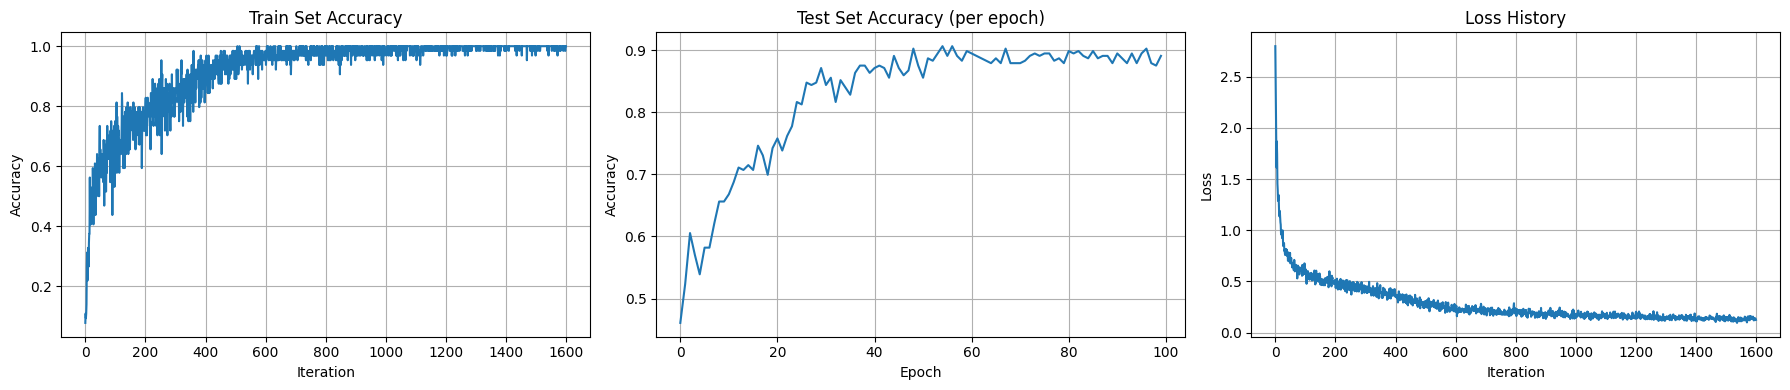


Final Test Accuracy: 89.06%
Best Test Accuracy During Training: 90.62%


In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)

# Plot Test Accuracy (per epoch)
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy (per epoch)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Cell 9: Final evaluation
final_test_acc = validate_model()
max_test_acc = max(test_acc_hist)

print(f"\nFinal Test Accuracy: {final_test_acc*100:.2f}%")
print(f"Best Test Accuracy During Training: {max_test_acc*100:.2f}%")

In [16]:
# Cell 10: Save the trained model
import pickle
from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the complete model state dictionary (recommended)
model_path = f'dvs_gesture_model_{timestamp}.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_acc': max(test_acc_hist),
    'test_acc_history': test_acc_hist,
    'loss_history': loss_hist,
    'train_acc_history': acc_hist,
}, model_path)
print(f"Model saved as: {model_path}")

# 2. Save just the model weights (lighter file)
weights_path = f'dvs_gesture_weights_{timestamp}.pth'
torch.save(net.state_dict(), weights_path)
print(f"Model weights saved as: {weights_path}")

# 3. Save training history separately
history_path = f'training_history_{timestamp}.pkl'
with open(history_path, 'wb') as f:
    pickle.dump({
        'loss_hist': loss_hist,
        'acc_hist': acc_hist,
        'test_acc_hist': test_acc_hist,
    }, f)
print(f"Training history saved as: {history_path}")

# 4. Download files (for Google Colab)
try:
    from google.colab import files
    print("\nDownloading files...")
    files.download(model_path)
    files.download(weights_path)
    files.download(history_path)
    print("Files downloaded successfully!")
except ImportError:
    print("\nNot running in Colab. Files saved locally.")
    print(f"Files saved in current directory:")
    print(f"  - {model_path}")
    print(f"  - {weights_path}")
    print(f"  - {history_path}")

Model saved as: dvs_gesture_model_20251030_050432.pth
Model weights saved as: dvs_gesture_weights_20251030_050432.pth
Training history saved as: training_history_20251030_050432.pkl



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!


<Figure size 1000x800 with 0 Axes>

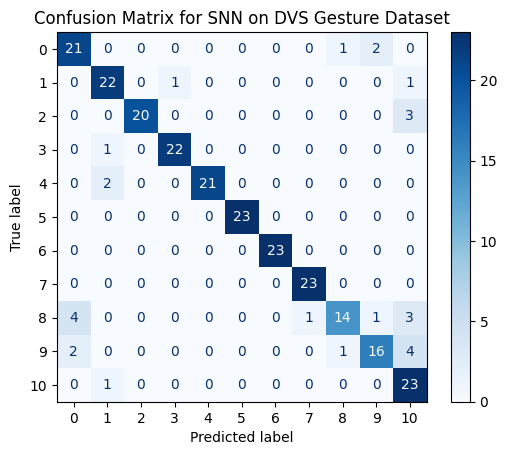

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------------------------
# Helper function to reset SNN state
# --------------------------------------
def reset_snn(net):
    """Reset all spiking layers' membrane potentials"""
    for layer in net.modules():
        if hasattr(layer, "reset_mem"):
            layer.reset_mem()

# --------------------------------------
# Evaluate model and collect predictions
# --------------------------------------
all_preds = []
all_labels = []

net.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        # Reset membrane potentials before processing new batch
        reset_snn(net)

        # Forward pass through time steps
        spk_rec = []
        for step in range(data.size(0)):     # each timestep
            spk_out, _ = net(data[step])
            spk_rec.append(spk_out)

        # Convert list to tensor: [time, batch, classes]
        spk_rec = torch.stack(spk_rec)

        # Sum spikes over time to get total firing count
        outputs = spk_rec.sum(dim=0)         # [batch, classes]

        # Predicted class = neuron with most spikes
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(targets.cpu())

# --------------------------------------
# Combine all batches
# --------------------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# --------------------------------------
# Confusion Matrix
# --------------------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for SNN on DVS Gesture Dataset")
plt.savefig("/kaggle/working/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

In [26]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=3))


              precision    recall  f1-score   support

           0      0.778     0.875     0.824        24
           1      0.846     0.917     0.880        24
           2      1.000     0.870     0.930        23
           3      0.957     0.957     0.957        23
           4      1.000     0.913     0.955        23
           5      1.000     1.000     1.000        23
           6      1.000     1.000     1.000        23
           7      0.958     1.000     0.979        23
           8      0.875     0.609     0.718        23
           9      0.842     0.696     0.762        23
          10      0.676     0.958     0.793        24

    accuracy                          0.891       256
   macro avg      0.903     0.890     0.891       256
weighted avg      0.901     0.891     0.890       256

